#Import

In [ ]:
!pip install dgl networkx scikit-learn python-louvain

In [ ]:
!pip install scikit-learn sentence-transformers dgl

In [ ]:
!pip install torch==2.0 torchvision

In [ ]:
import dgl
from dgl.data import CoraGraphDataset
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.sparse.linalg import eigsh
import community as community_louvain  # Импортируем правильно
import itertools
import random

In [ ]:
# Загрузка набора данных Cora
dataset = CoraGraphDataset()
g = dataset[0]

# Преобразование DGL графа в NetworkX граф
nx_g = g.to_networkx().to_undirected()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


#1 Traditional methods

In [300]:
def graph_partitioning(g, k):
    nodes = list(g.nodes())
    random.shuffle(nodes)
    A = set(nodes[:len(nodes) // 2])
    B = set(nodes[len(nodes) // 2:])
    partition = (A, B)
    clusters = [0 if node in A else 1 for node in g.nodes()]
    return clusters

def hierarchical_clustering(g, n_clusters):
    adjacency_matrix = nx.to_numpy_array(g)
    clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
    clustering.fit(adjacency_matrix)
    return clustering.labels_

def partitional_clustering(g, n_clusters):
    adjacency_matrix = nx.to_numpy_array(g)
    clustering = KMeans(n_clusters=n_clusters)
    clustering.fit(adjacency_matrix)
    return clustering.labels_

def spectral_clustering(g, n_clusters):
    laplacian = nx.normalized_laplacian_matrix(g).astype(float)
    eigenvalues, eigenvectors = eigsh(laplacian, k=n_clusters, which='SM')
    spectral = KMeans(n_clusters=n_clusters).fit(eigenvectors)
    return spectral.labels_

In [ ]:
%%time
partition_clusters = graph_partitioning(nx_g, 2)
print("Graph Partitioning Clusters:", partition_clusters)

Graph Partitioning Clusters: [{1, 2, 7, 8, 9, 10, 14, 17, 19, 22, 23, 24, 28, 29, 30, 31, 32, 33, 34, 35, 40, 41, 42, 43, 46, 48, 52, 53, 57, 58, 59, 61, 64, 65, 68, 69, 72, 73, 76, 80, 81, 83, 85, 87, 88, 90, 92, 95, 96, 97, 98, 100, 101, 105, 106, 108, 110, 111, 115, 120, 121, 125, 130, 131, 136, 140, 141, 142, 143, 147, 151, 152, 155, 156, 160, 161, 166, 167, 168, 170, 172, 173, 174, 175, 176, 179, 181, 182, 183, 184, 185, 186, 187, 188, 190, 193, 196, 197, 201, 203, 204, 208, 209, 211, 214, 218, 219, 220, 221, 223, 225, 227, 228, 229, 230, 231, 237, 239, 240, 242, 245, 246, 248, 249, 251, 252, 253, 254, 256, 257, 261, 262, 270, 271, 272, 274, 275, 276, 277, 278, 279, 280, 281, 285, 286, 290, 291, 295, 297, 298, 299, 300, 301, 304, 315, 316, 322, 324, 327, 328, 331, 332, 333, 334, 337, 338, 339, 340, 341, 346, 347, 355, 356, 357, 361, 362, 363, 366, 369, 372, 375, 376, 380, 385, 386, 387, 391, 393, 394, 396, 402, 403, 404, 408, 414, 415, 423, 424, 425, 431, 433, 435, 436, 439, 440, 

In [ ]:
%%time
hierarchical_clusters = hierarchical_clustering(nx_g, 7)
print("Hierarchical Clustering Labels:", hierarchical_clusters)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Hierarchical Clustering Labels: [0 0 0 ... 0 2 0]
CPU times: user 239 ms, sys: 152 ms, total: 391 ms
Wall time: 441 ms


In [ ]:
%%time
kmeans_clusters = partitional_clustering(nx_g, 7)
print("Partitional Clustering Labels:", kmeans_clusters)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Partitional Clustering Labels: [1 1 1 ... 1 1 1]
CPU times: user 3.5 s, sys: 1.11 s, total: 4.61 s
Wall time: 4.2 s


In [ ]:
%%time
spectral_clusters = spectral_clustering(nx_g, 7)
print("Spectral Clustering Labels:", spectral_clusters)

Spectral Clustering Labels: [0 0 0 ... 2 0 0]
CPU times: user 1.19 s, sys: 1.13 s, total: 2.32 s
Wall time: 2.97 s


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#2 Divisive Algorithms

In [ ]:
from networkx.algorithms.community import louvain_communities, label_propagation_communities

# Преобразование DGL графа в NetworkX граф
nx_g = g.to_networkx().to_undirected()
def louvain_clustering(g):
    return louvain_communities(g)
def label_propagation_clustering(g):
    return list(label_propagation_communities(g))

# Замер времени для каждого алгоритма кластеризации
start_time = time.time()
louvain_clusters = louvain_clustering(nx_g)
print("Louvain Clustering Clusters:", louvain_clusters)
print("Time taken for Louvain Clustering: {:.2f} seconds".format(time.time() - start_time))

start_time = time.time()
label_propagation_clusters = label_propagation_clustering(nx_g)
print("Label Propagation Clustering Clusters:", label_propagation_clusters)
print("Time taken for Label Propagation Clustering: {:.2f} seconds".format(time.time() - start_time))

Louvain Clustering Clusters: [{2544, 3}, {208, 7}, {514, 516, 1039, 2071, 25, 2593, 37, 1069, 2102, 55, 2104, 57, 2103, 572, 60, 65, 2116, 76, 593, 87, 88, 2137, 1630, 96, 98, 2152, 619, 2156, 1644, 621, 2164, 634, 1658, 1661, 2178, 1667, 1156, 130, 1668, 651, 2188, 1677, 2190, 2193, 2194, 1174, 1178, 1696, 161, 162, 164, 2217, 1713, 2227, 191, 1220, 1227, 204, 1741, 211, 214, 737, 2274, 1259, 239, 753, 1266, 755, 1269, 249, 1274, 1277, 2304, 771, 772, 1288, 1293, 2317, 272, 787, 1309, 1314, 2342, 300, 2350, 815, 818, 1843, 1332, 1845, 1847, 1848, 1338, 1851, 827, 323, 324, 325, 842, 2385, 851, 1880, 1882, 349, 355, 356, 2404, 1898, 2418, 2419, 1394, 1908, 885, 1909, 1912, 890, 1403, 2427, 2428, 382, 896, 908, 415, 2467, 2468, 419, 438, 1978, 1982, 1983, 1984, 1474, 454, 966, 1487, 1999, 465, 471, 2010, 2011, 2012, 2013, 2014, 479, 2016, 478, 2017, 2018, 2019, 2015, 2021, 2022, 2020, 2024, 995, 2023, 497, 498, 1521, 1013, 1527, 1529}, {106, 2461}, {2537, 259, 117}, {1208, 187}, {200, 2

#3 Modularity-based Methods

In [ ]:
!pip install cdlib

In [ ]:
!pip install python-louvain

In [ ]:
from community import community_louvain

In [ ]:
import networkx.algorithms.community as nx_comm
def louvain_clustering(g):
    partition = community_louvain.best_partition(g)
    return partition
def simulated_annealing_clustering(g):
    partition = nx_comm.modularity_max.greedy_modularity_communities(g)
    return {node: i for i, community in enumerate(partition) for node in community}
def simulated_annealing_clustering_labels(g):
    partition = simulated_annealing_clustering(g)
    return [partition[node] for node in sorted(partition)]

In [ ]:
louvain_clusters = louvain_clustering(nx_g)
print("Louvain Clustering Partition:", louvain_clusters)

simulated_annealing_clusters = simulated_annealing_clustering(nx_g)
print("Simulated Annealing Clustering Partition:", simulated_annealing_clusters)


Louvain Clustering Partition: {0: 0, 1: 1, 2: 1, 3: 2, 4: 36, 5: 4, 6: 5, 7: 6, 8: 36, 9: 7, 10: 8, 11: 9, 12: 10, 13: 11, 14: 11, 15: 12, 16: 4, 17: 0, 18: 8, 19: 13, 20: 14, 21: 15, 22: 16, 23: 17, 24: 0, 25: 18, 26: 19, 27: 11, 28: 4, 29: 16, 30: 9, 31: 20, 32: 15, 33: 21, 34: 4, 35: 22, 36: 8, 37: 18, 38: 11, 39: 43, 40: 13, 41: 15, 42: 15, 43: 16, 44: 25, 45: 11, 46: 4, 47: 14, 48: 1, 49: 1, 50: 30, 51: 27, 52: 5, 53: 4, 54: 0, 55: 18, 56: 15, 57: 18, 58: 4, 59: 4, 60: 18, 61: 9, 62: 5, 63: 11, 64: 4, 65: 18, 66: 29, 67: 30, 68: 0, 69: 15, 70: 30, 71: 0, 72: 4, 73: 4, 74: 5, 75: 31, 76: 18, 77: 9, 78: 11, 79: 8, 80: 5, 81: 5, 82: 43, 83: 4, 84: 31, 85: 28, 86: 9, 87: 18, 88: 18, 89: 16, 90: 33, 91: 21, 92: 17, 93: 14, 94: 28, 95: 5, 96: 15, 97: 30, 98: 18, 99: 19, 100: 5, 101: 36, 102: 8, 103: 8, 104: 28, 105: 4, 106: 35, 107: 14, 108: 17, 109: 8, 110: 7, 111: 4, 112: 8, 113: 30, 114: 30, 115: 15, 116: 18, 117: 37, 118: 14, 119: 14, 120: 9, 121: 8, 122: 19, 123: 19, 124: 8, 125: 2

#4 Dynamic Algorithms

In [ ]:
def random_walk_clustering(g, n_clusters, walk_length=4):
    adjacency_matrix = nx.to_numpy_array(g)
    rw_matrix = np.linalg.matrix_power(adjacency_matrix, walk_length)
    clustering = KMeans(n_clusters=n_clusters)
    clustering.fit(rw_matrix)
    return clustering.labels_

def spin_model_clustering(g, num_clusters, max_iterations=500):
    nodes = list(g.nodes())
    spins = {node: random.randint(0, num_clusters-1) for node in nodes}

    for _ in range(max_iterations):
        for node in nodes:
            neighbor_spins = [spins[neighbor] for neighbor in g.neighbors(node)]
            most_common_spin = max(set(neighbor_spins), key=neighbor_spins.count)
            spins[node] = most_common_spin

    return [spins[node] for node in sorted(spins)]

def synchronization_clustering(g, num_clusters, max_iterations=500):
    nodes = list(g.nodes())
    phases = np.random.rand(len(nodes)) * 2 * np.pi

    adjacency_matrix = nx.to_numpy_array(g)
    for _ in range(max_iterations):
        sin_diff = np.sin(phases[:, None] - phases[None, :])
        phases += 0.1 * np.dot(adjacency_matrix, sin_diff).sum(axis=1)
        phases = np.mod(phases, 2 * np.pi)

    clustering = KMeans(n_clusters=num_clusters)
    clustering.fit(phases[:, None])
    return clustering.labels_


In [ ]:
random_walk_clusters = random_walk_clustering(nx_g, 7)
print("Random Walk Clustering Labels:", random_walk_clusters)

spin_model_clusters = spin_model_clustering(nx_g, 7)
print("Spin Model Clustering Labels:", spin_model_clusters)

start_time = time.time()
synchronization_labels = synchronization_clustering(nx_g, 7)
print("Synchronization Clustering Labels:", synchronization_labels)
print("Time taken for Synchronization Clustering: {:.2f} seconds".format(time.time() - start_time))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Random Walk Clustering Labels: [0 0 5 ... 0 0 0]
Spin Model Clustering Labels: [6, 1, 1, 6, 6, 0, 0, 6, 0, 2, 0, 0, 6, 0, 4, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 2, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 6, 2, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 4, 1, 0, 0, 5, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 1, 1, 3, 0, 0, 4, 0, 2, 0, 0, 0, 0, 4, 0, 1, 1, 2, 2, 0, 1, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 1, 0, 4, 1, 2, 2, 0, 0, 0, 5, 4, 0, 0, 0, 0, 2, 0, 0, 0, 6, 6, 1, 0, 3, 4, 4, 0, 0, 0, 6, 0, 5, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 2, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 4, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 5, 6, 0, 0, 4, 1, 4, 1, 0, 1, 3, 6, 0, 6, 4, 4, 5, 0, 0, 0, 1, 0, 0, 1, 4, 6, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 2, 0, 1, 0, 1, 2, 0, 0, 0, 5, 3, 0, 0, 1, 1, 0, 0, 1, 0, 4, 0, 0, 0, 0, 0,

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#Comparison

In [ ]:
from sklearn.metrics import normalized_mutual_info_score
import community as community_louvain
from community import community_louvain
import pandas as pd

In [293]:
dataset = CoraGraphDataset()
g = dataset[0]
nx_g = g.to_networkx().to_undirected()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [220]:
# Convert sets to lists for calculating the number of clusters
def count_clusters(clusters):
    if isinstance(clusters, set):
        return len(list(clusters))
    elif isinstance(clusters, list):
        return len(clusters)
    else:
        return 0

In [294]:
# Загрузка набора данных Cora
dataset = CoraGraphDataset()
g = dataset[0]

# Преобразование DGL графа в NetworkX граф
nx_g = g.to_networkx().to_undirected()

clustering_algorithms = {
    "Graph Partitioning": (graph_partitioning, {"k": 5}),
    "Hierarchical Clustering": (hierarchical_clustering, {"n_clusters": 5}),
    "Partitional Clustering": (partitional_clustering, {"n_clusters": 5}),
    "Spectral Clustering": (spectral_clustering, {"n_clusters": 5}),
    "Louvain Clustering": (louvain_clustering, {}),
    "Simulated Annealing Clustering": (simulated_annealing_clustering_labels, {}),
    "Random Walk Clustering": (random_walk_clustering, {"n_clusters": 5}),
    "Spin Model Clustering": (spin_model_clustering, {"num_clusters": 5}),
    ##"Synchronization Clustering": (synchronization_clustering, {"num_clusters": 5}),
}

results = []
for name, (func, kwargs) in clustering_algorithms.items():
    start_time = time.time()
    clusters = func(nx_g, **kwargs)
    duration = time.time() - start_time
    results.append((name, clusters, duration))

# Display clustering results
for name, clusters, duration in results:
    print(f"{name} Clusters:", clusters)
    print(f"Time taken for {name}: {duration:.2f} seconds")

# Create summary table
summary_data = {
    "Algorithm": [name for name, _, _ in results],
    "Time (seconds)": [duration for _, _, duration in results],
    "Number of Clusters": [len(list(clusters)) if isinstance(clusters, set) else len(clusters) if isinstance(clusters, list) else 1 for _, clusters, _ in results],
}
summary_table = pd.DataFrame(summary_data)
print(summary_table)


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Graph Partitioning Clusters: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1

<ipython-input-295-aef91089fb5d>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = {color: plt.cm.get_cmap('tab20')(i / len(unique_colors)) for i, color in enumerate(unique_colors)}
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


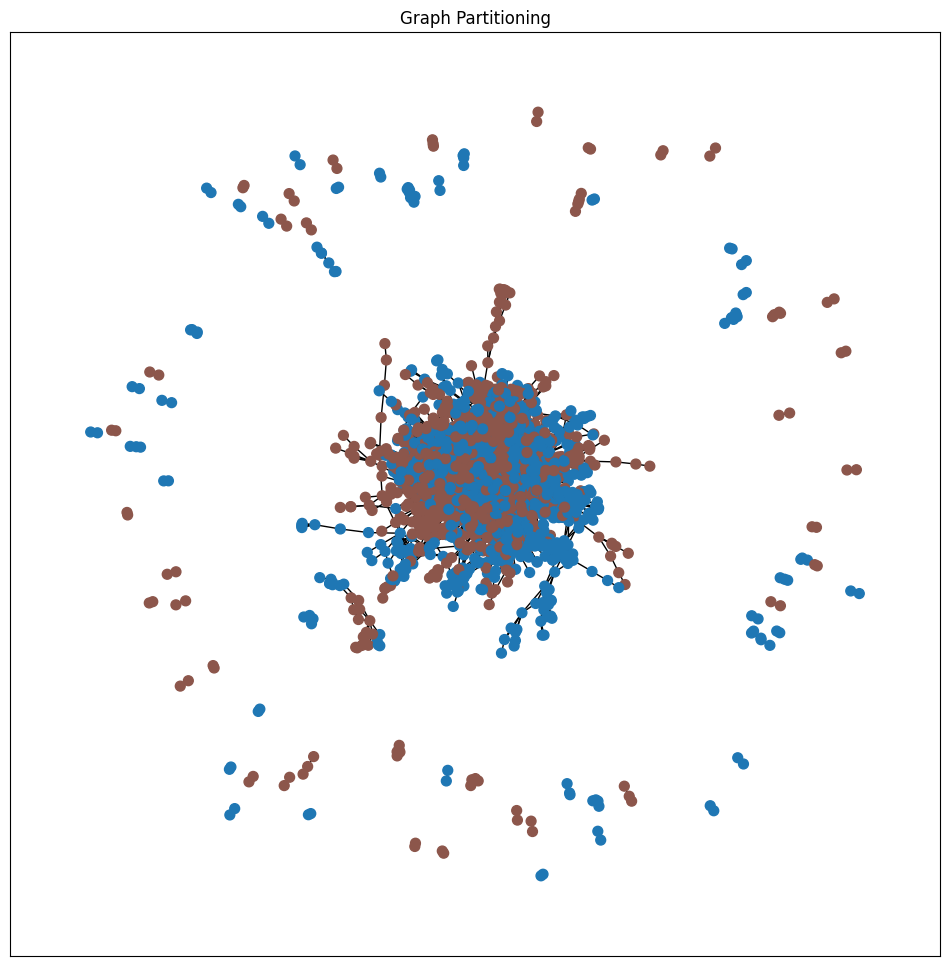

ValueError: Clusters should be either a list or a dict

In [295]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_graph_with_clusters(G, clusters, title):
    pos = nx.spring_layout(G)

    # Преобразование списка меток в словарь
    if isinstance(clusters, list):
        if len(clusters) != len(G.nodes):
            raise ValueError("Length of clusters list does not match the number of nodes in the graph")
        cluster_colors = {node: clusters[i] for i, node in enumerate(G.nodes)}
    elif isinstance(clusters, dict):
        cluster_colors = clusters
    else:
        raise ValueError("Clusters should be either a list or a dict")

    # Получение цветов для кластеров
    colors = [cluster_colors[node] for node in G.nodes]
    unique_colors = list(set(colors))
    color_map = {color: plt.cm.get_cmap('tab20')(i / len(unique_colors)) for i, color in enumerate(unique_colors)}
    node_colors = [color_map[color] for color in colors]

    # Визуализация графа
    plt.figure(figsize=(12, 12))
    nx.draw_networkx(G, pos, node_color=node_colors, with_labels=False, node_size=50, cmap=plt.cm.tab20)
    plt.title(title)
    plt.show()

# Пример использования
for name, clusters, _ in results:
    draw_graph_with_clusters(nx_g, clusters, name)


In [354]:
def compute_modularity(G, clusters, method):
    if method in ['Louvain Clustering', 'Spin Model Clustering']:
        # В этом случае clusters должен быть списком кластеров
        modularity = nx.algorithms.community.quality.modularity(G, clusters)
    elif method in ['Graph Partitioning', 'Partitional Clustering', 'Spectral Clustering', 'Simulated Annealing Clustering', 'Random Walk Clustering']:
        # Создаем список кластеров на основе индексов вершин
        cluster_set = set(clusters)
        num_clusters = len(cluster_set)
        partition = [[] for _ in range(num_clusters)]
        for i, cluster_id in enumerate(clusters):
            partition[cluster_id].append(i)
        modularity = nx.algorithms.community.quality.modularity(G, partition)
    elif method == 'Hierarchical Clustering':
        # Проверяем, что clusters является списком
        if not isinstance(clusters, list):
            print("Clusters is not a list for Hierarchical Clustering")
            return None
        # Проверяем, что каждый кластер содержит более одной вершины
        if any(len(sublist) <= 1 for sublist in clusters):
            print("Some clusters contain only one or no vertices for Hierarchical Clustering")
            return None
        # Преобразуем список списков вершин в список вершин
        clusters_flat = [vertex for sublist in clusters if isinstance(sublist, list) for vertex in sublist]
        if not clusters_flat:
            print("Empty clusters after flattening for Hierarchical Clustering")
            return None
        modularity = compute_modularity(nx_g, clusters_flat, method)
    else:
        print(f"Unknown clustering method: {method}")
        return None

    return modularity

def compute_partition_quality(G, clusters, method):
    if method in ['Louvain Clustering', 'Spin Model Clustering']:
        # В этом случае clusters должен быть списком кластеров
        partition_quality = nx.community.partition_quality(G, clusters)
    elif method in ['Graph Partitioning', 'Partitional Clustering', 'Spectral Clustering', 'Simulated Annealing Clustering', 'Random Walk Clustering']:
        # Создаем список кластеров на основе индексов вершин
        cluster_set = set(clusters)
        num_clusters = len(cluster_set)
        partition = [[] for _ in range(num_clusters)]
        for i, cluster_id in enumerate(clusters):
            partition[cluster_id].append(i)
        partition_quality = nx.community.partition_quality(G, partition)
    elif method == 'Hierarchical Clustering':
        # Проверяем, что clusters является списком
        if not isinstance(clusters, list):
            print("Clusters is not a list for Hierarchical Clustering")
            return None
        # Проверяем, что каждый кластер содержит более одной вершины
        if any(len(sublist) <= 1 for sublist in clusters):
            print("Some clusters contain only one or no vertices for Hierarchical Clustering")
            return None
        # Преобразуем список списков вершин в список вершин
        clusters_flat = [vertex for sublist in clusters if isinstance(sublist, list) for vertex in sublist]
        if not clusters_flat:
            print("Empty clusters after flattening for Hierarchical Clustering")
            return None
        partition_quality = nx.community.partition_quality(G, [clusters_flat])
    else:
        print(f"Unknown clustering method: {method}")
        return None

    return partition_quality

In [275]:
clusters

[{0,
  1,
  2,
  3,
  5,
  6,
  9,
  14,
  16,
  18,
  21,
  22,
  23,
  26,
  29,
  30,
  31,
  32,
  34,
  36,
  42,
  43,
  44,
  45,
  46,
  52,
  53,
  56,
  58,
  61,
  62,
  64,
  66,
  68,
  69,
  72,
  73,
  74,
  75,
  76,
  77,
  79,
  80,
  81,
  83,
  84,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  95,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  108,
  109,
  111,
  112,
  114,
  115,
  117,
  118,
  122,
  123,
  124,
  126,
  127,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  142,
  147,
  149,
  151,
  152,
  153,
  154,
  155,
  156,
  160,
  161,
  170,
  174,
  176,
  177,
  181,
  182,
  183,
  185,
  188,
  189,
  191,
  192,
  198,
  203,
  204,
  211,
  215,
  217,
  221,
  223,
  227,
  234,
  236,
  238,
  239,
  242,
  243,
  246,
  248,
  249,
  252,
  255,
  257,
  258,
  259,
  260,
  262,
  263,
  264,
  268,
  270,
  272,
  274,
  275,
  276,
  277,
  279,
  280,
  284,
  285,
  289,
  291,
  292,
  294,
  296,
  300,
  301,


In [356]:
modularities = []
coverages = []
efficiencies = []
times = []

for name, clusters, duration in results:
    if isinstance(clusters, int):
        clusters_list = [[clusters]]
    elif name in ['Louvain Clustering', 'Spin Model Clustering']:
        clusters_list = clusters
    elif name in ['Graph Partitioning', 'Partitional Clustering', 'Spectral Clustering', 'Simulated Annealing Clustering', 'Random Walk Clustering']:
        clusters_list = [cluster for cluster in clusters]  # Используем метки кластеров напрямую
    elif name == 'Hierarchical Clustering':
        clusters_list = clusters if isinstance(clusters, list) else [[cluster] for cluster in clusters]
    else:
        print(f"Unknown clustering method: {name}")
        continue

    print(name)
    print(f"Type of clusters_list: {type(clusters_list)}")
    print(f"Type of first element: {type(clusters_list[0])}")
    print(clusters_list[:5])

    modularity = compute_modularity(nx_g, clusters_list, name)
    partition_quality = compute_partition_quality(nx_g, clusters_list, name)

    if partition_quality is None:
        print(f"No partition quality computed for {name}")
        continue

    coverage = partition_quality[0]
    efficiency = partition_quality[1]

    modularities.append(modularity)
    coverages.append(coverage)
    efficiencies.append(efficiency)
    times.append(duration)


Graph Partitioning
Type of clusters_list: <class 'list'>
Type of first element: <class 'int'>
[0, 0, 0, 0, 0]
Hierarchical Clustering
Type of clusters_list: <class 'list'>
Type of first element: <class 'list'>
[[0], [0], [0], [0], [0]]
Some clusters contain only one or no vertices for Hierarchical Clustering
Some clusters contain only one or no vertices for Hierarchical Clustering
No partition quality computed for Hierarchical Clustering
Partitional Clustering
Type of clusters_list: <class 'list'>
Type of first element: <class 'numpy.int32'>
[1, 1, 1, 1, 1]
Spectral Clustering
Type of clusters_list: <class 'list'>
Type of first element: <class 'numpy.int32'>
[0, 0, 0, 0, 0]
Louvain Clustering
Type of clusters_list: <class 'dict'>
Type of first element: <class 'int'>


TypeError: unhashable type: 'slice'

In [360]:
print(modularities,coverages,efficiencies,times)

[0.4016642649010578, 0.12295663855815955, 0.04713052787199209] [0.9016672982190224, 0.8834785903751421, 0.9954528230390299] [-1.0, -1.0, -1.0] [0.15432262420654297, 5.20961332321167, 1.0759823322296143]


In [357]:

for name, clusters, duration in results:
    modularity = compute_modularity(nx_g, clusters)
    partition_quality = compute_partition_quality(nx_g, clusters)
    silhouette = partition_quality['silhouette']
    modularities.append(modularity)
    silhouettes.append(silhouette)
    times.append(duration)

algorithms = [name for name, _, _ in results]

plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.barh(algorithms, modularities, color='skyblue')
plt.xlabel('Modularity')
plt.title('Modularity of Clustering Algorithms')

plt.subplot(3, 1, 2)
plt.barh(algorithms, silhouettes, color='lightgreen')
plt.xlabel('Silhouette Score')
plt.title('Silhouette Score of Clustering Algorithms')

plt.subplot(3, 1, 3)
plt.barh(algorithms, times, color='lightcoral')
plt.xlabel('Time (seconds)')
plt.title('Time Taken by Clustering Algorithms')

plt.tight_layout()
plt.show()

TypeError: compute_modularity() missing 1 required positional argument: 'method'